# XXX

In [3]:
# XXX
import sys
sys.path.append('/cs/phd/nadavb/github_projects/protein_bert')

In [19]:
# # XXX
# from importlib import reload
# import proteinbert
# import proteinbert.finetuning
# import proteinbert.model_generation
# import proteinbert.conv_and_global_attention_model

# proteinbert.finetuning = reload(proteinbert.finetuning)
# proteinbert.model_generation = reload(proteinbert.model_generation)
# proteinbert.conv_and_global_attention_model = reload(proteinbert.conv_and_global_attention_model)
# proteinbert = reload(proteinbert)

# Fine-tune the model for the signalP benchmark

In [18]:
import os

import pandas as pd
from IPython.display import display

from tensorflow import keras

from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

BENCHMARKS_DIR = '/cs/phd/nadavb/my_public_ftp_site/protein_bert/protein_benchmarks'

BENCHMARK_NAME = 'signalP_binary'

# A local (non-global) bianry output
OUTPUT_TYPE = OutputType(False, 'binary')
UNIQUE_LABELS = [0, 1]
OUTPUT_SPEC = OutputSpec(OUTPUT_TYPE, UNIQUE_LABELS)


# Loading the dataset

train_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.train.csv' % BENCHMARK_NAME)
train_set = pd.read_csv(train_set_file_path).dropna().drop_duplicates()
train_set, valid_set = train_test_split(train_set, stratify = train_set['label'], test_size = 0.1, random_state = 0)

test_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.test.csv' % BENCHMARK_NAME)
test_set = pd.read_csv(test_set_file_path).dropna().drop_duplicates()

print(f'{len(train_set)} training set records, {len(valid_set)} validation set records, {len(test_set)} test set records.')


# Loading the pre-trained model and fine-tuning it on the loaded dataset

pretrained_model_generator, input_encoder = load_pretrained_model()

# get_model_with_hidden_layers_as_outputs gives the model output access to the hidden layers as well
model_generator = FinetuningModelGenerator(pretrained_model_generator, OUTPUT_SPEC, pretraining_model_manipulation_function = \
        get_model_with_hidden_layers_as_outputs)

training_callbacks = [
    keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-07, verbose = 1),
    keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
]

finetune(model_generator, input_encoder, OUTPUT_SPEC, train_set['seq'], train_set['label'], valid_set['seq'], valid_set['label'], \
        seq_len = 512, batch_size = 32, max_epochs_per_stage = 40, lr = 5e-05, begin_with_frozen_pretrained_layers = True, \
        lr_with_frozen_pretrained_layers = 1e-03, n_final_epochs = 1, final_seq_len = 4096, final_lr = 1e-05, callbacks = training_callbacks)


# Evaluating the performance on the test-set

results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, OUTPUT_SPEC, test_set['seq'], test_set['label'], \
        start_seq_len = 512, start_batch_size = 32)

print('Test-set performance:')
display(results)

print('Confusion matrix:')
display(confusion_matrix)

14945 training set records, 1661 validation set records, 4152 test set records.
[2021_03_31-14:57:27] Training set: Filtered out 0 of 14945 (0.0%) records of lengths exceeding 510.
[2021_03_31-14:57:27] Validation set: Filtered out 0 of 1661 (0.0%) records of lengths exceeding 510.
[2021_03_31-14:57:27] Training with frozen pretrained layers...
Epoch 1/2
468/468 [==============================] - 24s 43ms/step - loss: 0.2464 - val_loss: 0.0901
Epoch 2/2
468/468 [==============================] - 19s 41ms/step - loss: 0.0790 - val_loss: 0.0751
[2021_03_31-14:58:13] Training the entire fine-tuned model...
[2021_03_31-14:58:18] Incompatible number of optimizer weights - will not initialize them.
Epoch 1/2
468/468 [==============================] - 53s 106ms/step - loss: 0.0579 - val_loss: 0.0559
Epoch 2/2
468/468 [==============================] - 48s 103ms/step - loss: 0.0452 - val_loss: 0.0507
[2021_03_31-15:00:01] Training on final epochs of sequence length 4096...
[2021_03_31-15:00:01

,# records,AUC
Model seq len,,
512,4152,0.993608
All,4152,0.993608


Confusion matrix:


,0,1
0,3417,61
1,23,651


# Run all benchmarks

In [62]:
import os

import pandas as pd
from IPython.display import display

from tensorflow import keras

from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len, log
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

BENCHMARKS_DIR = '/cs/phd/nadavb/my_public_ftp_site/protein_bert/protein_benchmarks'

BENCHMARKS = [
    # name, output_type
    ('signalP_binary', OutputType(False, 'binary')),
    ('fluorescence', OutputType(False, 'numeric')),
    ('remote_homology', OutputType(False, 'categorical')),
    ('stability', OutputType(False, 'numeric')),
    ('scop', OutputType(False, 'categorical')),
    ('secondary_structure', OutputType(True, 'categorical')),
    ('disorder_secondary_structure', OutputType(True, 'binary')),
    ('ProFET_NP_SP_Cleaved', OutputType(False, 'binary')),
    ('phosphoserine', OutputType(True, 'binary')),
    ('PhosphositePTM', OutputType(True, 'binary')),
]

settings = {
    'max_dataset_size': None,
    'max_epochs_per_stage': 40,
    'seq_len': 512,
    'batch_size': 32,
    'final_epoch_seq_len': 4096,
    'initial_lr_with_frozen_pretrained_layers': 1e-03,
    'initial_lr_with_all_layers': 5e-05,
    'final_epoch_lr': 1e-05,
    'training_callbacks': [
        keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-07, verbose = 1),
        keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
    ],
}

####### Uncomment for debug mode
# settings['max_dataset_size'] = 500
# settings['max_epochs_per_stage'] = 1

def run_benchmark(benchmark_name, pretraining_model_generator, input_encoder, pretraining_model_manipulation_function = None):
    
    log('========== %s ==========' % benchmark_name)  
    
    output_type = get_benchmark_output_type(benchmark_name)
    log('Output type: %s' % output_type)
    
    train_set, valid_set, test_set = load_benchmark_dataset(benchmark_name)        
    log(f'{len(train_set)} training set records, {len(valid_set)} validation set records, {len(test_set)} test set records.')
    
    if settings['max_dataset_size'] is not None:
        log('Limiting the training, validation and test sets to %d records each.' % settings['max_dataset_size'])
        train_set = train_set.sample(min(settings['max_dataset_size'], len(train_set)), random_state = 0)
        valid_set = valid_set.sample(min(settings['max_dataset_size'], len(valid_set)), random_state = 0)
        test_set = test_set.sample(min(settings['max_dataset_size'], len(test_set)), random_state = 0)
    
    if output_type.is_seq or output_type.is_categorical:
        train_set['label'] = train_set['label'].astype(str)
        valid_set['label'] = valid_set['label'].astype(str)
        test_set['label'] = test_set['label'].astype(str)
    else:
        train_set['label'] = train_set['label'].astype(float)
        valid_set['label'] = valid_set['label'].astype(float)
        test_set['label'] = test_set['label'].astype(float)
      
    if output_type.is_categorical:
        
        if output_type.is_seq:
            unique_labels = sorted(set.union(*train_set['label'].apply(set)) | set.union(*valid_set['label'].apply(set)) | \
                    set.union(*test_set['label'].apply(set)))
        else:
            unique_labels = sorted(set(train_set['label'].unique()) | set(valid_set['label'].unique()) | set(test_set['label'].unique()))
            
        log('%d unique lebels.' % len(unique_labels))
    elif output_type.is_binary:
        unique_labels = [0, 1]
    else:
        unique_labels = None
        
    output_spec = OutputSpec(output_type, unique_labels)
    model_generator = FinetuningModelGenerator(pretraining_model_generator, output_spec, pretraining_model_manipulation_function = \
            pretraining_model_manipulation_function)
    finetune(model_generator, input_encoder, output_spec, train_set['seq'], train_set['label'], valid_set['seq'], valid_set['label'], \
            seq_len = settings['seq_len'], batch_size = settings['batch_size'], max_epochs_per_stage = settings['max_epochs_per_stage'], \
            lr = settings['initial_lr_with_all_layers'], begin_with_frozen_pretrained_layers = True, lr_with_frozen_pretrained_layers = \
            settings['initial_lr_with_frozen_pretrained_layers'], n_final_epochs = 1, final_seq_len = settings['final_epoch_seq_len'], \
            final_lr = settings['final_epoch_lr'], callbacks = settings['training_callbacks'])
    
    for dataset_name, dataset in [('Training-set', train_set), ('Validation-set', valid_set), ('Test-set', test_set)]:
        
        log('*** %s performance: ***' % dataset_name)
        results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, output_spec, dataset['seq'], dataset['label'], \
                start_seq_len = settings['seq_len'], start_batch_size = settings['batch_size'])
    
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(results)
        
        if confusion_matrix is not None:
            with pd.option_context('display.max_rows', 16, 'display.max_columns', 10):
                log('Confusion matrix:')
                display(confusion_matrix)
                
    return model_generator

def load_benchmark_dataset(benchmark_name):
    
    train_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.train.csv' % benchmark_name)
    valid_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.valid.csv' % benchmark_name)
    test_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.test.csv' % benchmark_name)
    
    train_set = pd.read_csv(train_set_file_path).dropna().drop_duplicates()
    test_set = pd.read_csv(test_set_file_path).dropna().drop_duplicates()
          
    if os.path.exists(valid_set_file_path):
        valid_set = pd.read_csv(valid_set_file_path).dropna().drop_duplicates()
    else:
        log(f'Validation set {valid_set_file_path} missing. Splitting training set instead.')
        train_set, valid_set = train_test_split(train_set, stratify = train_set['label'], test_size = 0.1, random_state = 0)
    
    return train_set, valid_set, test_set

def get_benchmark_output_type(benchmark_name):
    for name, output_type in BENCHMARKS:
        if name == benchmark_name:
            return output_type
        
pretrained_model_generator, input_encoder = load_pretrained_model()

for benchmark_name, _ in BENCHMARKS:
    run_benchmark(benchmark_name, pretrained_model_generator, input_encoder, pretraining_model_manipulation_function = \
            get_model_with_hidden_layers_as_outputs)
        
log('Done.')

[2021_03_30-11:45:12] ========== signalP_binary ==========
[2021_03_30-11:45:12] Output type: global binary
[2021_03_30-11:45:12] Validation set /tmp/protein_benchmarks/signalP_binary.valid.csv missing. Splitting training set instead.
[2021_03_30-11:45:12] Stratification did not work, randomly sampling instead.
[2021_03_30-11:45:12] 14945 training set records, 1661 validation set records, 4152 test set records.
[2021_03_30-11:45:12] Training set: Filtered out 0 of 14945 (0.0%) records of lengths exceeding 510.
[2021_03_30-11:45:13] Validation set: Filtered out 0 of 1661 (0.0%) records of lengths exceeding 510.
[2021_03_30-11:45:13] Training with frozen pretrained layers...
Epoch 1/40
468/468 [==============================] - 26s 44ms/step - loss: 0.2337 - val_loss: 0.0927
Epoch 2/40
468/468 [==============================] - 19s 41ms/step - loss: 0.0828 - val_loss: 0.0733
Epoch 3/40
468/468 [==============================] - 20s 42ms/step - loss: 0.0679 - val_loss: 0.0647
Epoch 4/40
4

,# records,AUC
Model seq len,,
512,14945,0.998338
All,14945,0.998338


[2021_03_30-12:00:20] Confusion matrix:


,0,1
0,12363,146
1,34,2402


[2021_03_30-12:00:20] *** Validation-set performance: ***


,# records,AUC
Model seq len,,
512,1661,0.99384
All,1661,0.99384


[2021_03_30-12:00:24] Confusion matrix:


,0,1
0,1374,25
1,13,249


[2021_03_30-12:00:24] *** Test-set performance: ***


,# records,AUC
Model seq len,,
512,4152,0.991844
All,4152,0.991844


[2021_03_30-12:00:31] Confusion matrix:


,0,1
0,3410,68
1,25,649


[2021_03_30-12:00:31] ========== fluorescence ==========
[2021_03_30-12:00:31] Output type: global numeric
[2021_03_30-12:00:31] 21446 training set records, 5362 validation set records, 27217 test set records.
[2021_03_30-12:00:31] Training set: Filtered out 0 of 21446 (0.0%) records of lengths exceeding 510.
[2021_03_30-12:00:31] Validation set: Filtered out 0 of 5362 (0.0%) records of lengths exceeding 510.
[2021_03_30-12:00:31] Training with frozen pretrained layers...
Epoch 1/40
671/671 [==============================] - 37s 49ms/step - loss: 1.8887 - val_loss: 1.5346
Epoch 2/40
671/671 [==============================] - 31s 46ms/step - loss: 0.9758 - val_loss: 0.9114
Epoch 3/40
671/671 [==============================] - 31s 46ms/step - loss: 0.9159 - val_loss: 0.8320
Epoch 4/40
671/671 [==============================] - 31s 46ms/step - loss: 0.8635 - val_loss: 0.7241
Epoch 5/40
671/671 [==============================] - 31s 46ms/step - loss: 0.9412 - val_loss: 1.1507

Epoch 00005:

,# records,Spearman's rank correlation
Model seq len,,
512,21446,0.603969
All,21446,0.603969


[2021_03_30-13:05:00] *** Validation-set performance: ***


,# records,Spearman's rank correlation
Model seq len,,
512,5362,0.591254
All,5362,0.591254


[2021_03_30-13:05:07] *** Test-set performance: ***


,# records,Spearman's rank correlation
Model seq len,,
512,27217,0.581355
All,27217,0.581355


[2021_03_30-13:05:40] ========== remote_homology ==========
[2021_03_30-13:05:40] Output type: global categorical
[2021_03_30-13:05:40] 12311 training set records, 736 validation set records, 718 test set records.
[2021_03_30-13:05:40] 1195 unique lebels.
[2021_03_30-13:05:40] Training set: Filtered out 153 of 12311 (1.2%) records of lengths exceeding 510.
[2021_03_30-13:05:40] Validation set: Filtered out 13 of 736 (1.8%) records of lengths exceeding 510.
[2021_03_30-13:05:40] Training with frozen pretrained layers...
Epoch 1/40
380/380 [==============================] - 22s 45ms/step - loss: 27.6582 - val_loss: 36.1769
Epoch 2/40
380/380 [==============================] - 16s 41ms/step - loss: 33.4885 - val_loss: 38.5754

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 3/40
380/380 [==============================] - 16s 41ms/step - loss: 22.1901 - val_loss: 16.6940
Epoch 4/40
380/380 [==============================] - 16s 42ms/step - loss: 12.786

,# records,Accuracy
Model seq len,,
512,12158,0.038493
1024,146,0.061644
2048,7,0.000000
All,12311,0.038746


[2021_03_30-13:20:46] Confusion matrix:


,0,1,10,100,1000,...,995,996,997,998,999
0,0,1,0,0,0,...,0,0,0,0,0
1,0,8,0,0,0,...,0,0,0,0,0
10,0,0,0,0,0,...,0,0,0,0,0
100,0,0,0,0,0,...,0,0,0,0,0
1000,0,0,0,0,0,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,...,0,0,0,0,0
996,0,0,0,0,0,...,0,0,0,0,0
997,0,0,0,0,0,...,0,0,0,0,0
998,0,0,0,0,0,...,0,0,0,0,0


[2021_03_30-13:20:46] *** Validation-set performance: ***


,# records,Accuracy
Model seq len,,
512,723,0.005533
1024,11,0.000000
2048,2,0.000000
All,736,0.005435


[2021_03_30-13:20:52] Confusion matrix:


,0,1,10,100,1000,...,995,996,997,998,999
0,0,1,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
10,0,0,0,0,0,...,0,0,0,0,0
100,0,0,0,0,0,...,0,0,0,0,0
1000,0,0,0,0,0,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,...,0,0,0,0,0
996,0,0,0,0,0,...,0,0,0,0,0
997,0,0,0,0,0,...,0,0,0,0,0
998,0,0,0,0,0,...,0,0,0,0,0


[2021_03_30-13:20:52] *** Test-set performance: ***


,# records,Accuracy
Model seq len,,
512,711,0.015471
1024,7,0.000000
All,718,0.015320


[2021_03_30-13:20:57] Confusion matrix:


,0,1,10,100,1000,...,995,996,997,998,999
0,0,1,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
10,0,0,0,0,0,...,0,0,0,0,0
100,0,0,0,0,0,...,0,0,0,0,0
1000,0,0,0,0,0,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,...,0,0,0,0,0
996,0,0,0,0,0,...,0,0,0,0,0
997,0,0,0,0,0,...,0,0,0,0,0
998,0,0,0,0,0,...,0,0,0,0,0


[2021_03_30-13:20:57] ========== stability ==========
[2021_03_30-13:20:57] Output type: global numeric
[2021_03_30-13:20:57] 53613 training set records, 2512 validation set records, 12851 test set records.
[2021_03_30-13:20:57] Training set: Filtered out 0 of 53613 (0.0%) records of lengths exceeding 510.
[2021_03_30-13:20:58] Validation set: Filtered out 0 of 2512 (0.0%) records of lengths exceeding 510.
[2021_03_30-13:20:58] Training with frozen pretrained layers...
Epoch 1/40
1676/1676 [==============================] - 72s 41ms/step - loss: 1.1120 - val_loss: 0.4175
Epoch 2/40
1676/1676 [==============================] - 65s 39ms/step - loss: 0.4841 - val_loss: 0.4354

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 3/40
1676/1676 [==============================] - 65s 39ms/step - loss: 0.3207 - val_loss: 0.3940
Epoch 4/40
1676/1676 [==============================] - 65s 39ms/step - loss: 0.3384 - val_loss: 0.5192

Epoch 00004: ReduceLROnPlate

,# records,Spearman's rank correlation
Model seq len,,
512,53613,0.677492
All,53613,0.677492


[2021_03_30-14:06:56] *** Validation-set performance: ***


,# records,Spearman's rank correlation
Model seq len,,
512,2512,0.675636
All,2512,0.675636


[2021_03_30-14:07:02] *** Test-set performance: ***


,# records,Spearman's rank correlation
Model seq len,,
512,12851,0.635623
All,12851,0.635623


[2021_03_30-14:07:18] ========== scop ==========
[2021_03_30-14:07:18] Output type: global categorical
[2021_03_30-14:07:18] Validation set /tmp/protein_benchmarks/scop.valid.csv missing. Splitting training set instead.
[2021_03_30-14:07:18] Stratification did not work, randomly sampling instead.
[2021_03_30-14:07:18] 14112 training set records, 1568 validation set records, 3921 test set records.
[2021_03_30-14:07:18] 7 unique lebels.
[2021_03_30-14:07:18] Training set: Filtered out 7 of 14112 (0.0%) records of lengths exceeding 510.
[2021_03_30-14:07:19] Validation set: Filtered out 0 of 1568 (0.0%) records of lengths exceeding 510.
[2021_03_30-14:07:19] Training with frozen pretrained layers...
Epoch 1/40
441/441 [==============================] - 25s 47ms/step - loss: 2.8315 - val_loss: 1.2662
Epoch 2/40
441/441 [==============================] - 18s 41ms/step - loss: 1.5454 - val_loss: 1.7146

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 3/4

,# records,Accuracy
Model seq len,,
512,14105,0.720454
1024,7,0.571429
All,14112,0.720380


[2021_03_30-14:25:14] Confusion matrix:


,a,b,c,d,e,f,g
a,2271,1,23,26,13,8,1
b,11,2286,100,306,215,78,1
c,193,2,3209,20,723,21,0
d,372,75,629,1612,625,43,0
e,40,2,31,1,191,3,0
f,19,3,1,1,9,161,0
g,101,120,4,125,0,0,436


[2021_03_30-14:25:14] *** Validation-set performance: ***


,# records,Accuracy
Model seq len,,
512,1568,0.625638
All,1568,0.625638


[2021_03_30-14:25:17] Confusion matrix:


,a,b,c,d,e,f,g
a,234,2,13,18,4,2,0
b,7,188,19,44,29,6,0
c,34,1,339,9,108,4,0
d,54,21,80,144,71,8,0
e,6,0,1,0,13,2,0
f,4,2,2,1,2,13,0
g,12,9,2,10,0,0,50


[2021_03_30-14:25:17] *** Test-set performance: ***


,# records,Accuracy
Model seq len,,
512,3919,0.625670
1024,2,0.000000
All,3921,0.625351


[2021_03_30-14:25:26] Confusion matrix:


,a,b,c,d,e,f,g
a,571,3,22,44,7,5,2
b,14,511,73,125,70,29,1
c,76,7,832,18,225,8,0
d,134,66,224,332,165,12,0
e,11,0,9,3,47,3,0
f,8,3,0,1,1,42,0
g,32,30,3,35,0,0,117


[2021_03_30-14:25:26] ========== secondary_structure ==========
[2021_03_30-14:25:26] Output type: categorical sequence
[2021_03_30-14:25:26] 8678 training set records, 2170 validation set records, 434 test set records.
[2021_03_30-14:25:26] 3 unique lebels.
[2021_03_30-14:25:26] Training set: Filtered out 570 of 8678 (6.6%) records of lengths exceeding 510.
[2021_03_30-14:25:26] Validation set: Filtered out 138 of 2170 (6.4%) records of lengths exceeding 510.
[2021_03_30-14:25:26] Training with frozen pretrained layers...
Epoch 1/40
254/254 [==============================] - 18s 51ms/step - loss: 0.4728 - val_loss: 0.4070
Epoch 2/40
254/254 [==============================] - 12s 47ms/step - loss: 0.4008 - val_loss: 0.3981
Epoch 3/40
254/254 [==============================] - 12s 47ms/step - loss: 0.3951 - val_loss: 0.3951
Epoch 4/40
254/254 [==============================] - 12s 46ms/step - loss: 0.3951 - val_loss: 0.3969

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.000

,# records,Accuracy
Model seq len,,
512,1834580,0.715187
1024,351854,0.686103
2048,35073,0.682377
All,2221507,0.710063


[2021_03_30-14:44:47] Confusion matrix:


,0,1,2
0,584107,33598,181381
1,55304,248574,171578
2,128880,73357,744728


[2021_03_30-14:44:47] *** Validation-set performance: ***


,# records,Accuracy
Model seq len,,
512,464337,0.709743
1024,84878,0.689660
2048,7716,0.686884
All,556931,0.706366


[2021_03_30-14:44:55] Confusion matrix:


,0,1,2
0,151311,8844,47082
1,14513,58859,41546
2,33648,17901,183227


[2021_03_30-14:44:55] *** Test-set performance: ***


,# records,Accuracy
Model seq len,,
512,85550,0.695383
1024,21222,0.681745
All,106772,0.692672


[2021_03_30-14:44:59] Confusion matrix:


,0,1,2
0,25477,1923,8991
1,2731,11779,8806
2,6017,4346,36702


[2021_03_30-14:44:59] ========== disorder_secondary_structure ==========
[2021_03_30-14:44:59] Output type: binary sequence
[2021_03_30-14:44:59] 8678 training set records, 2170 validation set records, 434 test set records.
[2021_03_30-14:44:59] Training set: Filtered out 570 of 8678 (6.6%) records of lengths exceeding 510.
[2021_03_30-14:45:00] Validation set: Filtered out 138 of 2170 (6.4%) records of lengths exceeding 510.
[2021_03_30-14:45:00] Training with frozen pretrained layers...
Epoch 1/40
254/254 [==============================] - 19s 57ms/step - loss: 0.1071 - val_loss: 0.0848
Epoch 2/40
254/254 [==============================] - 12s 46ms/step - loss: 0.0808 - val_loss: 0.0822
Epoch 3/40
254/254 [==============================] - 12s 46ms/step - loss: 0.0805 - val_loss: 0.0812
Epoch 4/40
254/254 [==============================] - 12s 46ms/step - loss: 0.0794 - val_loss: 0.0814

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/40
254/25

,# records,AUC
Model seq len,,
512,1834580,0.920791
1024,351854,0.879032
2048,35073,0.774544
All,2221507,0.912440


[2021_03_30-15:11:19] Confusion matrix:


,0,1
0,77714,66959
1,30611,2046223


[2021_03_30-15:11:19] *** Validation-set performance: ***


,# records,AUC
Model seq len,,
512,464337,0.899761
1024,84878,0.887410
2048,7716,0.905504
All,556931,0.899337


[2021_03_30-15:11:28] Confusion matrix:


,0,1
0,17757,17161
1,8225,513788


[2021_03_30-15:11:28] *** Test-set performance: ***


,# records,AUC
Model seq len,,
512,85550,0.855693
1024,21222,0.839718
All,106772,0.850876


[2021_03_30-15:11:33] Confusion matrix:


,0,1
0,1160,1645
1,1546,102421


[2021_03_30-15:11:33] ========== ProFET_NP_SP_Cleaved ==========
[2021_03_30-15:11:33] Output type: global binary
[2021_03_30-15:11:33] 2727 training set records, 303 validation set records, 337 test set records.
[2021_03_30-15:11:33] Training set: Filtered out 520 of 2727 (19.1%) records of lengths exceeding 510.
[2021_03_30-15:11:33] Validation set: Filtered out 58 of 303 (19.1%) records of lengths exceeding 510.
[2021_03_30-15:11:33] Training with frozen pretrained layers...
Epoch 1/40
69/69 [==============================] - 9s 65ms/step - loss: 1.1080 - val_loss: 0.4051
Epoch 2/40
69/69 [==============================] - 3s 41ms/step - loss: 0.5280 - val_loss: 0.3648
Epoch 3/40
69/69 [==============================] - 3s 41ms/step - loss: 0.4761 - val_loss: 0.3716

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 4/40
69/69 [==============================] - 3s 41ms/step - loss: 0.4505 - val_loss: 0.3476
Epoch 5/40
69/69 [======================

,# records,AUC
Model seq len,,
512,2207,0.921511
1024,351,0.873909
2048,136,0.607407
4096,26,NaN
8192,7,NaN
All,2727,0.935143


[2021_03_30-15:14:34] Confusion matrix:


,0,1
0,190,680
1,19,1838


[2021_03_30-15:14:34] *** Validation-set performance: ***


,# records,AUC
Model seq len,,
512,245,0.936078
1024,41,0.782051
2048,13,NaN
4096,3,NaN
8192,1,NaN
All,303,0.939145


[2021_03_30-15:14:44] Confusion matrix:


,0,1
0,20,57
1,1,225


[2021_03_30-15:14:44] *** Test-set performance: ***


,# records,AUC
Model seq len,,
512,267,0.937396
1024,45,1.000000
2048,18,NaN
4096,6,NaN
8192,1,NaN
All,337,0.952422


[2021_03_30-15:14:54] Confusion matrix:


,0,1
0,27,78
1,1,231


[2021_03_30-15:14:54] ========== phosphoserine ==========
[2021_03_30-15:14:54] Output type: binary sequence
[2021_03_30-15:14:54] 3836 training set records, 427 validation set records, 474 test set records.
[2021_03_30-15:14:54] Training set: Filtered out 2276 of 3836 (59.3%) records of lengths exceeding 510.
[2021_03_30-15:14:54] Validation set: Filtered out 244 of 427 (57.1%) records of lengths exceeding 510.
[2021_03_30-15:14:54] Training with frozen pretrained layers...
Epoch 1/40
49/49 [==============================] - 7s 66ms/step - loss: 0.0342 - val_loss: 0.0147
Epoch 2/40
49/49 [==============================] - 2s 41ms/step - loss: 0.0159 - val_loss: 0.0135
Epoch 3/40
49/49 [==============================] - 2s 41ms/step - loss: 0.0136 - val_loss: 0.0133
Epoch 4/40
49/49 [==============================] - 2s 41ms/step - loss: 0.0134 - val_loss: 0.0131
Epoch 5/40
49/49 [==============================] - 2s 41ms/step - loss: 0.0131 - val_loss: 0.0131

Epoch 00005: ReduceLROnP

,# records,AUC
Model seq len,,
512,257295,0.627790
1024,511169,0.566192
2048,477883,0.552320
4096,188362,0.582448
8192,57039,0.578582
All,1491748,0.575885


[2021_03_30-15:18:24] Confusion matrix:


,0,1
0,1484451,0
1,7297,0


[2021_03_30-15:18:24] *** Validation-set performance: ***


,# records,AUC
Model seq len,,
512,29951,0.535535
1024,51315,0.538643
2048,57734,0.596506
4096,24397,0.539203
8192,2323,0.202412
All,165720,0.553225


[2021_03_30-15:18:35] Confusion matrix:


,0,1
0,165004,0
1,716,0


[2021_03_30-15:18:35] *** Test-set performance: ***


,# records,AUC
Model seq len,,
512,31992,0.555964
1024,63363,0.526677
2048,58499,0.590020
4096,24877,0.575102
8192,5095,0.491014
16384,4399,0.289078
All,188225,0.543695


[2021_03_30-15:18:47] Confusion matrix:


,0,1
0,187361,0
1,864,0


[2021_03_30-15:18:47] ========== PhosphositePTM ==========
[2021_03_30-15:18:47] Output type: binary sequence
[2021_03_30-15:18:48] 43356 training set records, 4825 validation set records, 8508 test set records.
[2021_03_30-15:18:48] Training set: Filtered out 18426 of 43356 (42.5%) records of lengths exceeding 510.
[2021_03_30-15:18:49] Validation set: Filtered out 2062 of 4825 (42.7%) records of lengths exceeding 510.
[2021_03_30-15:18:49] Training with frozen pretrained layers...
Epoch 1/40
780/780 [==============================] - 38s 42ms/step - loss: 0.0515 - val_loss: 0.0368
Epoch 2/40
780/780 [==============================] - 32s 41ms/step - loss: 0.0380 - val_loss: 0.0362
Epoch 3/40
780/780 [==============================] - 32s 41ms/step - loss: 0.0375 - val_loss: 0.0368

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 4/40
780/780 [==============================] - 32s 41ms/step - loss: 0.0369 - val_loss: 0.0357
Epoch 5/40
780/780 [===

,# records,AUC
Model seq len,,
512,7439719,0.956170
1024,8931566,0.947380
2048,6457352,0.945074
4096,2399373,0.944766
8192,862534,0.940529
16384,57495,0.873732
32768,26926,NaN
65536,137282,0.917164
All,26312247,0.948761


[2021_03_30-16:03:50] Confusion matrix:


,0,1
0,25882667,1453
1,425051,3076


[2021_03_30-16:03:50] *** Validation-set performance: ***


,# records,AUC
Model seq len,,
512,823459,0.950407
1024,1029074,0.945586
2048,677731,0.943319
4096,285021,0.942711
8192,77959,0.934047
16384,8749,0.983934
All,2901993,0.945776


[2021_03_30-16:04:20] Confusion matrix:


,0,1
0,2854652,161
1,46879,301


[2021_03_30-16:04:20] *** Test-set performance: ***


,# records,AUC
Model seq len,,
512,1476347,0.949531
1024,1697696,0.946383
2048,1222679,0.946295
4096,545823,0.940955
8192,222772,0.938878
16384,8886,0.941065
All,5174203,0.946217


[2021_03_30-16:05:04] Confusion matrix:


,0,1
0,5091428,308
1,81931,536


[2021_03_30-16:05:04] Done.


# Visualizing the attention layers

You can run this only after you have fine-tuned the model on a benchmark (e.g. signalP) and obtained **model_generator**.

Text(0.5, 1.0, 'signalP_binary fine-tuning')

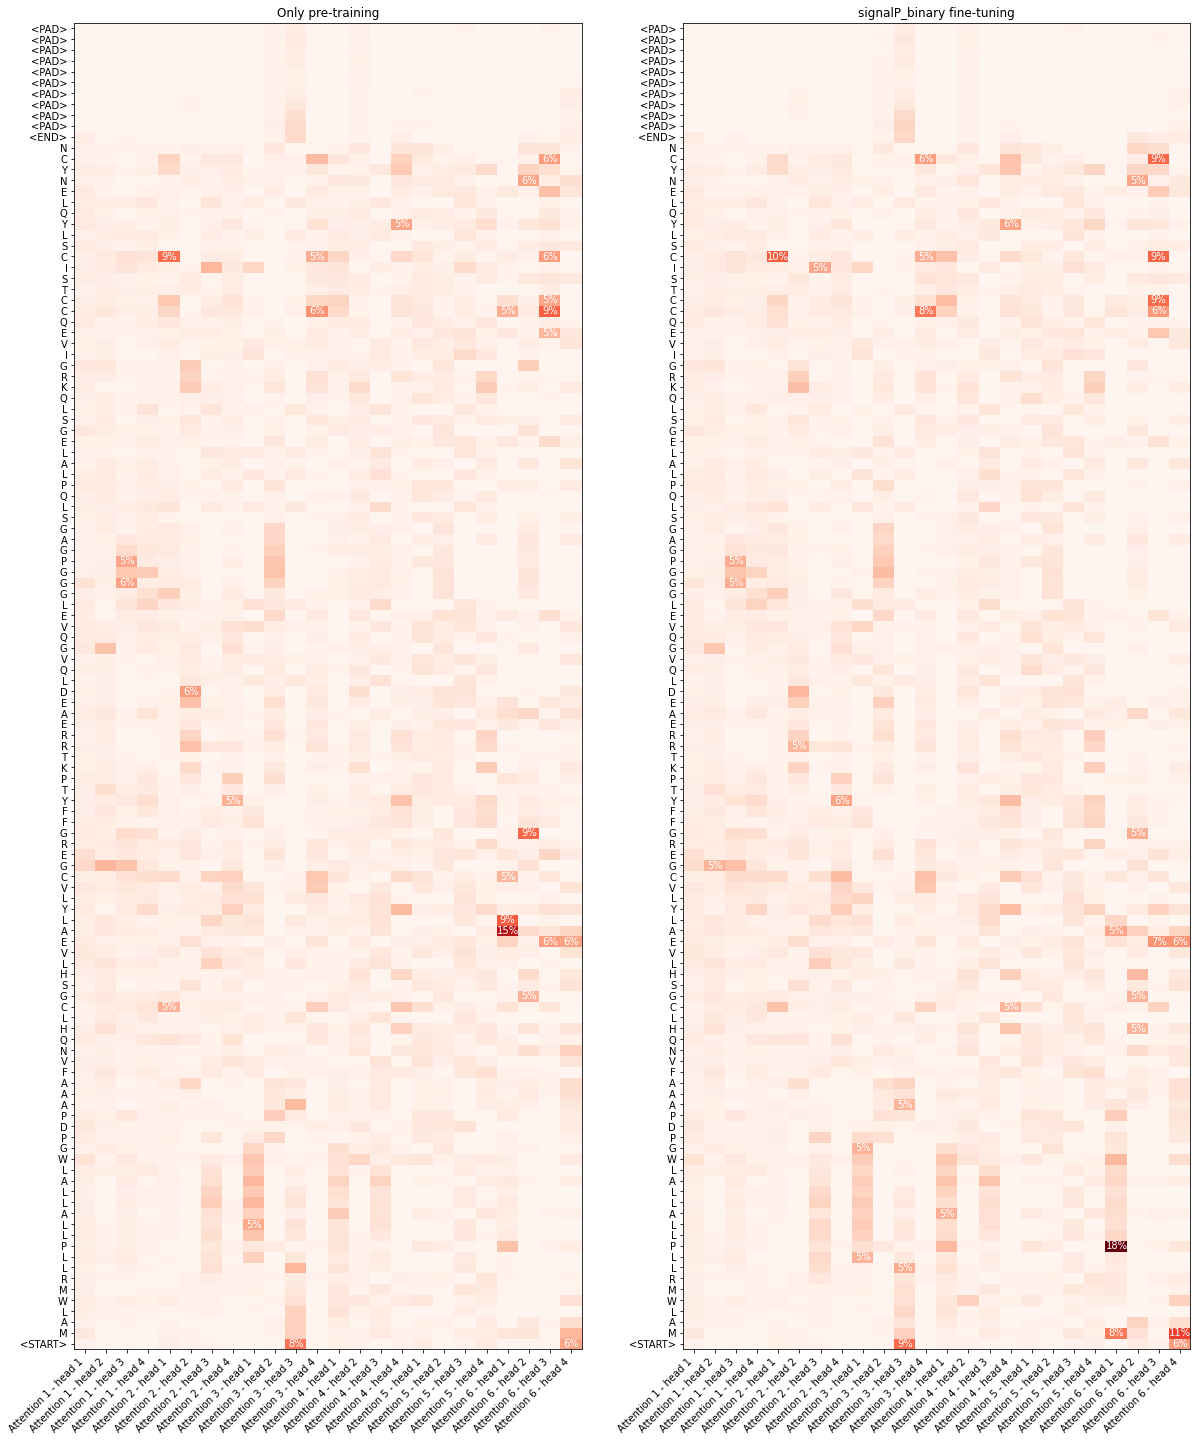

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_attentions(model, input_encoder, seq, seq_len = None):
    
    from tensorflow.keras import backend as K
    from proteinbert.tokenization import index_to_token
    
    if seq_len is None:
        seq_len = len(seq) + 2
    
    X = input_encoder.encode_X([seq], seq_len)
    (X_seq,), _ = X
    seq_tokens = list(map(index_to_token.get, X_seq))

    model_inputs = [layer.input for layer in model.layers if 'InputLayer' in str(type(layer))][::-1]
    model_attentions = [layer.calculate_attention(layer.input) for layer in model.layers if 'GlobalAttention' in str(type(layer))]
    invoke_model_attentions = K.function(model_inputs, model_attentions)
    attention_values = invoke_model_attentions(X)
    
    attention_labels = []
    merged_attention_values = []

    for attention_layer_index, attention_layer_values in enumerate(attention_values):
        for head_index, head_values in enumerate(attention_layer_values):
            attention_labels.append('Attention %d - head %d' % (attention_layer_index + 1, head_index + 1))
            merged_attention_values.append(head_values)

    attention_values = np.array(merged_attention_values)
    
    return attention_values, seq_tokens, attention_labels

def plot_attention(attention_values, seq_tokens, attention_labels, ax, cmap = 'Reds', vmax = None, text_value_threshold = 0.1):

    if vmax is None:
        vmax = attention_values.max()
    
    heatmap = ax.pcolor(attention_values.transpose(), cmap = cmap, vmin = 0, vmax = vmax)

    ax.set_xticks(np.arange(len(attention_labels)) + 0.5)
    ax.set_xticklabels(attention_labels, rotation = 45, ha = 'right')
    ax.set_yticks(np.arange(len(seq_tokens)) + 0.5)
    ax.set_yticklabels(seq_tokens)

    for i, row in enumerate(attention_values):
        for j, value in enumerate(row):
            if value >= text_value_threshold:
                ax.text(i + 0.5, j + 0.5, '%d%%' % (100 * value), color = 'white', ha = 'center', va = 'center')
                
SEQ = 'MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN'
# SEQ = 'MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANWMCLAKWESGYNTRATNYNAGDRSTDYGIFQINSRYWCNDGKTPGAVNACHLSCSALLQDNIADAVACAKRVVRDPQGIRAWVAWRNRCQNRDVRQYVQGCGV'
# SEQ = 'MSRSVALAVLALLSLSGLEAIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWSFYLLYYTEFTPTEKDEYACRVNHVTLSQPKIVKWDRDM'
# SEQ = 'MKTLLLLAVIMIFGLLQAHGNLVNFHRMIKLTTGKEAALSYGFYGCHCGVGGRGSPKDATDRCCVTHDCCYKRLEKRGCGTKFLSYKFSNSGSRITCAKQDSCRSQLCECDKAAATCFARNKTTYNKKYQYYSNKHCRGSTPRC'
# SEQ = 'MAGPLRAPLLLLAILAVALAVSPAAGSSPGKPPRLVGGPMDASVEEEGVRRALDFAVGEYNKASNDMYHSRALQVVRARKQIVAGVNYFLDVELGRTTCTKTQPNLDNCPFHDQPHLKRKAFCSFQIYAVPWQGTMTLSKSTCQDA'
# SEQ = 'MTSKLAVALLAAFLISAALCEGAVLPRSAKELRCQCIKTYSKPFHPKFIKELRVIESGPHCANTEIIVKLSDGRELCLDPKENWVQRVVEKFLKRAENS'
# SEQ = 'MKLLVLAVLLTVAAADSGISPRAVWQFRKMIKCVIPGSDPFLEYNNYGCYCGLGGSGTPVDELDKCCQTHDNCYDQAKKLDSCKFLLDNPYTHTYSYSCSGSAITCSSKNKECEAFICNCDRNAAICFSKAPYNKAHKNLDTKKYCQS'
seq_len = len(SEQ) + 2 + 10

pretrained_model_generator, input_encoder = load_pretrained_model()
model = pretrained_model_generator.create_model(seq_len)
pretrained_attention_values, seq_tokens, attention_labels = calculate_attentions(model, input_encoder, SEQ, seq_len = seq_len)

model = model_generator.create_model(seq_len)
finetuned_attention_values, _, _ = calculate_attentions(model, input_encoder, SEQ, seq_len = seq_len)

vmax = max(pretrained_attention_values.max(), finetuned_attention_values.max())

fig, axes = plt.subplots(ncols = 2, figsize = (20, 0.2 * seq_len))
plot_attention(pretrained_attention_values, seq_tokens, attention_labels, axes[0], cmap = 'Reds', vmax = vmax, text_value_threshold = 0.05)
axes[0].set_title('Only pre-training')
plot_attention(finetuned_attention_values, seq_tokens, attention_labels, axes[1], cmap = 'Reds', vmax = vmax, text_value_threshold = 0.05)
axes[1].set_title('%s fine-tuning' % BENCHMARK_NAME)